In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Sequential, losses, optimizers
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_recall_curve
from sklearn.model_selection import KFold,StratifiedKFold

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
def build_network():
    os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\based_model\原数据\K_CNN_OH')
    cnn = load_model('dataoh.h5')
    cnn.trainable = True #固定所有预训练模型层的参数
    base_model = Model(inputs=cnn.layers[0].input,outputs=cnn.layers[8].output)
    base_model.summary()
    base_model.trainable = True
    for layer in base_model.layers[:8]:
        layer.trainable = False
    Dense = tf.keras.layers.Dense(64,activation=tf.nn.relu)
    global_average_layer = tf.keras.layers.GlobalAveragePooling1D()
    prediction_layer = tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
    model1 = tf.keras.Sequential([
        base_model,
        #layers.Conv1D(filters=128, kernel_size=3, padding='same', activation=tf.nn.relu),
        #layers.Dropout(0.5),
        Dense,
        #layers.Dropout(0.3),
        global_average_layer,
        prediction_layer
    ])
    base_learning_rate = 0.001
    model1.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate), loss='binary_crossentropy',metrics=['accuracy'])#编译模型
    #model1.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    #base_learning_rate = 0.01
    #model1.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])
    model1.summary()
    return model1

In [4]:
def One_hot_raw(path):
    seqs = open(path).readlines()

    X1 = [seq.split()[1] for seq in seqs if seq.strip() != '']
    y = [int(seq.split()[0]) for seq in seqs if seq.strip() != '']
    One = []
    for i in range(0, len(X1)):
        One.append(list(X1[i]))
    X = pd.DataFrame(One)
    return np.array(X), np.array(y)


def one_hot(rawDataFrame, codingMode=0):  # rawDataFrame is numpy.ndarray

    sampleSeq3DArr = rawDataFrame[:, :]

    if codingMode == 0:
        probMatr = convertSampleToProbMatr(sampleSeq3DArr)

    return probMatr


def convertSampleToProbMatr(sampleSeq3DArr):  # changed add one column for '1'

    letterDict = {"A": 0, "C": 1, "D": 2, "E": 3, "F": 4, "G": 5, "H": 6, "I": 7, "K": 8, "L": 9, "M": 10, "N": 11,
                  "P": 12, "Q": 13, "R": 14, "S": 15, "T": 16, "V": 17, "W": 18, "Y": 19, "X": 20}
    AACategoryLen = 21  # add -

    probMatr = np.zeros((len(sampleSeq3DArr), 1, len(sampleSeq3DArr[0]), AACategoryLen))

    sampleNo = 0
    for sequence in sampleSeq3DArr:

        AANo = 0
        for AA in sequence:

            if not AA in letterDict:
                probMatr[sampleNo][0][AANo] = np.full((1, AACategoryLen), 1.0 / AACategoryLen)

            else:
                index = letterDict[AA]
                probMatr[sampleNo][0][AANo][index] = 1

            AANo += 1
        sampleNo += 1

    return probMatr

In [5]:
def preprocess(x, y):
    x = tf.cast(x, dtype=tf.float32)
    y = tf.cast(y, dtype=tf.int32)
    return x, y

In [6]:
batch_size=256

In [7]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\data\NEDD\不自然数据\1正2345负')
epochs = 300
x_train,y_train = One_hot_raw('train.txt')#十折交叉验证10
x_test,y_test = One_hot_raw('test.txt')#独立测试1

In [8]:
classes = sorted(list(set(y_train)))
x_train = one_hot(x_train)
x_test = one_hot(x_test)
x_train.shape = (x_train.shape[0],x_train.shape[2],x_train.shape[3])
x_test.shape = (x_test.shape[0],x_test.shape[2],x_test.shape[3])

In [9]:
# 构建独立测试集对象，预处理，批量化
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_db = test_db.map(preprocess).batch(batch_size)

In [10]:
prediction_result_cv = []
prediction_result_ind = []

In [11]:
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all')

In [12]:
out = os.getcwd() + '\\'

In [13]:
from sklearn.model_selection import KFold,StratifiedKFold
kf = StratifiedKFold(n_splits=10,shuffle=True)
for n_fold,(tr_idx,val_idx)in enumerate(kf.split(x_train,y_train)):
    tr_x,tr_y,val_x,val_y = x_train[tr_idx],y_train[tr_idx],x_train[val_idx],y_train[val_idx]
    # 构建训练集对象，随机打乱，预处理，批量化
    train_db = tf.data.Dataset.from_tensor_slices((tr_x, tr_y))
    train_db = train_db.shuffle(len(tr_x)).map(preprocess).batch(batch_size)
    # 构建测试集对象，预处理，批量化
    valid_db = tf.data.Dataset.from_tensor_slices((val_x, val_y))
    valid_db = valid_db.map(preprocess).batch(batch_size)
    #if not os.path.exists('%s_%d.h5' % (out, n_fold)):
    model1 = build_network()
    best_saving = tf.keras.callbacks.ModelCheckpoint(filepath='%s_%d.h5' % (out, n_fold), monitor='val_loss',verbose=1, save_best_only=True, save_weights_only=False)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
    history = model1.fit(train_db, epochs=epochs, validation_data=valid_db, verbose=2,callbacks=[best_saving, early_stopping], batch_size=batch_size)
    #network.load_weights('%s_%d.h5' % (out, n_fold))
    #history = network.fit(train_db, epochs=50, validation_data=valid_db, verbose=2)
    scores1 = model1.predict(val_x, batch_size=batch_size)[:, 0]
    score_val = pd.DataFrame(scores1)
    y_val = pd.DataFrame(val_y)
    datav=pd.concat([score_val,y_val],axis=1)
    print(n_fold + 1) 
    n_fold_str = str(n_fold + 1)
    pathv ='val_out'+ n_fold_str
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\result\val\\'+pathv+'.csv',encoding='utf-8')
    datav.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\result\valtxt\\'+pathv+'.txt',sep='\t',index=False,encoding='utf-8')
    scores2 = model1.predict(x_test, batch_size=batch_size)[:, 0]
    score_indep = pd.DataFrame(scores2)
    test_y = pd.DataFrame(y_test)
    datai = pd.concat([score_indep,test_y],axis=1)
    pathi ='indep_out'+ n_fold_str
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\result\indep\\'+pathi+'.csv',encoding='utf-8')
    datai.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\result\indeptxt\\'+pathi+'.txt',sep='\t',index=False,encoding='utf-8')

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_input (InputLayer)    [(None, 41, 21)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 41, 128)           2816      
_________________________________________________________________
dropout (Dropout)            (None, 41, 128)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 128)           49280     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 10, 128)           0     

8/8 - 0s - loss: 0.6656 - accuracy: 0.5947 - val_loss: 0.6799 - val_accuracy: 0.5911

Epoch 00021: val_loss did not improve from 0.67974
Epoch 22/300
8/8 - 0s - loss: 0.6652 - accuracy: 0.5887 - val_loss: 0.6796 - val_accuracy: 0.5911

Epoch 00022: val_loss improved from 0.67974 to 0.67956, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_0.h5
Epoch 23/300
8/8 - 0s - loss: 0.6617 - accuracy: 0.5937 - val_loss: 0.6792 - val_accuracy: 0.5867

Epoch 00023: val_loss improved from 0.67956 to 0.67920, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_0.h5
Epoch 24/300
8/8 - 0s - loss: 0.6646 - accuracy: 0.5833 - val_loss: 0.6783 - val_accuracy: 0.5867

Epoch 00024: val_loss improved from 0.67920 to 0.67827, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all

8/8 - 0s - loss: 0.6624 - accuracy: 0.5907 - val_loss: 0.6727 - val_accuracy: 0.6000

Epoch 00057: val_loss did not improve from 0.67252
Epoch 58/300
8/8 - 0s - loss: 0.6565 - accuracy: 0.6218 - val_loss: 0.6731 - val_accuracy: 0.6000

Epoch 00058: val_loss did not improve from 0.67252
Epoch 59/300
8/8 - 0s - loss: 0.6526 - accuracy: 0.6209 - val_loss: 0.6726 - val_accuracy: 0.6000

Epoch 00059: val_loss did not improve from 0.67252
Epoch 60/300
8/8 - 0s - loss: 0.6577 - accuracy: 0.6006 - val_loss: 0.6719 - val_accuracy: 0.6044

Epoch 00060: val_loss improved from 0.67252 to 0.67189, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_0.h5
Epoch 61/300
8/8 - 0s - loss: 0.6544 - accuracy: 0.6050 - val_loss: 0.6722 - val_accuracy: 0.6000

Epoch 00061: val_loss did not improve from 0.67189
Epoch 62/300
8/8 - 0s - loss: 0.6587 - accuracy: 0.6006 - val_loss: 0.6714 - val_accuracy: 0.6044

Epoch 00062: val_loss im

8/8 - 0s - loss: 0.6596 - accuracy: 0.5937 - val_loss: 0.6679 - val_accuracy: 0.6000

Epoch 00096: val_loss did not improve from 0.66729
Epoch 97/300
8/8 - 0s - loss: 0.6544 - accuracy: 0.6115 - val_loss: 0.6676 - val_accuracy: 0.5956

Epoch 00097: val_loss did not improve from 0.66729
Epoch 98/300
8/8 - 0s - loss: 0.6537 - accuracy: 0.6031 - val_loss: 0.6677 - val_accuracy: 0.6000

Epoch 00098: val_loss did not improve from 0.66729
Epoch 99/300
8/8 - 0s - loss: 0.6496 - accuracy: 0.6218 - val_loss: 0.6670 - val_accuracy: 0.6089

Epoch 00099: val_loss improved from 0.66729 to 0.66697, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_0.h5
Epoch 100/300
8/8 - 0s - loss: 0.6549 - accuracy: 0.6090 - val_loss: 0.6677 - val_accuracy: 0.6000

Epoch 00100: val_loss did not improve from 0.66697
Epoch 101/300
8/8 - 0s - loss: 0.6592 - accuracy: 0.6060 - val_loss: 0.6678 - val_accuracy: 0.6089

Epoch 00101: val_loss 

8/8 - 0s - loss: 0.6473 - accuracy: 0.6130 - val_loss: 0.6645 - val_accuracy: 0.6400

Epoch 00142: val_loss improved from 0.66465 to 0.66451, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_0.h5
Epoch 143/300
8/8 - 0s - loss: 0.6515 - accuracy: 0.6293 - val_loss: 0.6648 - val_accuracy: 0.6311

Epoch 00143: val_loss did not improve from 0.66451
Epoch 144/300
8/8 - 0s - loss: 0.6467 - accuracy: 0.6125 - val_loss: 0.6647 - val_accuracy: 0.6222

Epoch 00144: val_loss did not improve from 0.66451
Epoch 145/300
8/8 - 0s - loss: 0.6465 - accuracy: 0.6174 - val_loss: 0.6651 - val_accuracy: 0.6311

Epoch 00145: val_loss did not improve from 0.66451
Epoch 146/300
8/8 - 0s - loss: 0.6467 - accuracy: 0.6228 - val_loss: 0.6652 - val_accuracy: 0.6178

Epoch 00146: val_loss did not improve from 0.66451
Epoch 147/300
8/8 - 0s - loss: 0.6475 - accuracy: 0.6293 - val_loss: 0.6649 - val_accuracy: 0.6267

Epoch 00147: val_lo


Epoch 00186: val_loss did not improve from 0.66129
Epoch 187/300
8/8 - 0s - loss: 0.6383 - accuracy: 0.6377 - val_loss: 0.6619 - val_accuracy: 0.6444

Epoch 00187: val_loss did not improve from 0.66129
Epoch 188/300
8/8 - 0s - loss: 0.6445 - accuracy: 0.6243 - val_loss: 0.6614 - val_accuracy: 0.6400

Epoch 00188: val_loss did not improve from 0.66129
Epoch 189/300
8/8 - 0s - loss: 0.6442 - accuracy: 0.6263 - val_loss: 0.6605 - val_accuracy: 0.6444

Epoch 00189: val_loss improved from 0.66129 to 0.66047, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_0.h5
Epoch 190/300
8/8 - 0s - loss: 0.6419 - accuracy: 0.6298 - val_loss: 0.6603 - val_accuracy: 0.6489

Epoch 00190: val_loss improved from 0.66047 to 0.66029, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_0.h5
Epoch 191/300
8/8 - 0s - loss: 0.6441 - accuracy: 0.6327 - val_l


Epoch 00232: val_loss improved from 0.65821 to 0.65756, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_0.h5
Epoch 233/300
8/8 - 0s - loss: 0.6324 - accuracy: 0.6337 - val_loss: 0.6585 - val_accuracy: 0.6267

Epoch 00233: val_loss did not improve from 0.65756
Epoch 234/300
8/8 - 0s - loss: 0.6411 - accuracy: 0.6253 - val_loss: 0.6583 - val_accuracy: 0.6533

Epoch 00234: val_loss did not improve from 0.65756
Epoch 235/300
8/8 - 0s - loss: 0.6379 - accuracy: 0.6456 - val_loss: 0.6576 - val_accuracy: 0.6444

Epoch 00235: val_loss did not improve from 0.65756
Epoch 236/300
8/8 - 0s - loss: 0.6324 - accuracy: 0.6312 - val_loss: 0.6581 - val_accuracy: 0.6489

Epoch 00236: val_loss did not improve from 0.65756
Epoch 237/300
8/8 - 0s - loss: 0.6447 - accuracy: 0.6303 - val_loss: 0.6588 - val_accuracy: 0.6444

Epoch 00237: val_loss did not improve from 0.65756
Epoch 238/300
8/8 - 0s - loss: 0.6415 - accuracy: 0.6


Epoch 00278: val_loss did not improve from 0.65551
Epoch 279/300
8/8 - 0s - loss: 0.6373 - accuracy: 0.6451 - val_loss: 0.6562 - val_accuracy: 0.6267

Epoch 00279: val_loss did not improve from 0.65551
Epoch 280/300
8/8 - 0s - loss: 0.6395 - accuracy: 0.6322 - val_loss: 0.6555 - val_accuracy: 0.6356

Epoch 00280: val_loss did not improve from 0.65551
Epoch 281/300
8/8 - 0s - loss: 0.6379 - accuracy: 0.6327 - val_loss: 0.6555 - val_accuracy: 0.6400

Epoch 00281: val_loss did not improve from 0.65551
Epoch 282/300
8/8 - 0s - loss: 0.6395 - accuracy: 0.6204 - val_loss: 0.6561 - val_accuracy: 0.6444

Epoch 00282: val_loss did not improve from 0.65551
Epoch 283/300
8/8 - 0s - loss: 0.6356 - accuracy: 0.6406 - val_loss: 0.6565 - val_accuracy: 0.6489

Epoch 00283: val_loss did not improve from 0.65551
Epoch 284/300
8/8 - 0s - loss: 0.6342 - accuracy: 0.6372 - val_loss: 0.6572 - val_accuracy: 0.6311

Epoch 00284: val_loss did not improve from 0.65551
Epoch 285/300
8/8 - 0s - loss: 0.6382 - ac

8/8 - 0s - loss: 0.6764 - accuracy: 0.5729 - val_loss: 0.6841 - val_accuracy: 0.6356

Epoch 00008: val_loss improved from 0.68485 to 0.68405, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 9/300
8/8 - 0s - loss: 0.6732 - accuracy: 0.5902 - val_loss: 0.6830 - val_accuracy: 0.6222

Epoch 00009: val_loss improved from 0.68405 to 0.68296, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 10/300
8/8 - 0s - loss: 0.6749 - accuracy: 0.5863 - val_loss: 0.6823 - val_accuracy: 0.6311

Epoch 00010: val_loss improved from 0.68296 to 0.68234, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 11/300
8/8 - 0s - loss: 0.6716 - accuracy: 0.5952 - val_loss: 0.6814 - val_accuracy: 0.6267

Epoch 00011: val_loss improved from 0.68234 t

8/8 - 0s - loss: 0.6549 - accuracy: 0.6130 - val_loss: 0.6728 - val_accuracy: 0.6444

Epoch 00038: val_loss improved from 0.67302 to 0.67284, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 39/300
8/8 - 0s - loss: 0.6616 - accuracy: 0.6070 - val_loss: 0.6732 - val_accuracy: 0.6489

Epoch 00039: val_loss did not improve from 0.67284
Epoch 40/300
8/8 - 0s - loss: 0.6591 - accuracy: 0.5868 - val_loss: 0.6733 - val_accuracy: 0.6444

Epoch 00040: val_loss did not improve from 0.67284
Epoch 41/300
8/8 - 0s - loss: 0.6600 - accuracy: 0.6110 - val_loss: 0.6724 - val_accuracy: 0.6489

Epoch 00041: val_loss improved from 0.67284 to 0.67243, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 42/300
8/8 - 0s - loss: 0.6620 - accuracy: 0.6021 - val_loss: 0.6725 - val_accuracy: 0.6444

Epoch 00042: val_loss did not impr

8/8 - 0s - loss: 0.6535 - accuracy: 0.5991 - val_loss: 0.6686 - val_accuracy: 0.6578

Epoch 00074: val_loss improved from 0.66874 to 0.66857, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 75/300
8/8 - 0s - loss: 0.6584 - accuracy: 0.6070 - val_loss: 0.6687 - val_accuracy: 0.6667

Epoch 00075: val_loss did not improve from 0.66857
Epoch 76/300
8/8 - 0s - loss: 0.6522 - accuracy: 0.6065 - val_loss: 0.6683 - val_accuracy: 0.6578

Epoch 00076: val_loss improved from 0.66857 to 0.66830, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 77/300
8/8 - 0s - loss: 0.6587 - accuracy: 0.6001 - val_loss: 0.6687 - val_accuracy: 0.6489

Epoch 00077: val_loss did not improve from 0.66830
Epoch 78/300
8/8 - 0s - loss: 0.6535 - accuracy: 0.6134 - val_loss: 0.6680 - val_accuracy: 0.6489

Epoch 00078: val_loss improved fro


Epoch 00114: val_loss did not improve from 0.66571
Epoch 115/300
8/8 - 0s - loss: 0.6527 - accuracy: 0.6174 - val_loss: 0.6655 - val_accuracy: 0.6533

Epoch 00115: val_loss improved from 0.66571 to 0.66548, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 116/300
8/8 - 0s - loss: 0.6531 - accuracy: 0.6159 - val_loss: 0.6650 - val_accuracy: 0.6533

Epoch 00116: val_loss improved from 0.66548 to 0.66497, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 117/300
8/8 - 0s - loss: 0.6551 - accuracy: 0.6100 - val_loss: 0.6647 - val_accuracy: 0.6533

Epoch 00117: val_loss improved from 0.66497 to 0.66472, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 118/300
8/8 - 0s - loss: 0.6611 - accuracy: 0.6110 - val_loss: 0.6649

8/8 - 0s - loss: 0.6499 - accuracy: 0.6149 - val_loss: 0.6634 - val_accuracy: 0.6667

Epoch 00157: val_loss did not improve from 0.66309
Epoch 158/300
8/8 - 0s - loss: 0.6435 - accuracy: 0.6248 - val_loss: 0.6628 - val_accuracy: 0.6400

Epoch 00158: val_loss improved from 0.66309 to 0.66284, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 159/300
8/8 - 0s - loss: 0.6505 - accuracy: 0.6303 - val_loss: 0.6632 - val_accuracy: 0.6533

Epoch 00159: val_loss did not improve from 0.66284
Epoch 160/300
8/8 - 0s - loss: 0.6518 - accuracy: 0.6209 - val_loss: 0.6628 - val_accuracy: 0.6400

Epoch 00160: val_loss improved from 0.66284 to 0.66282, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 161/300
8/8 - 0s - loss: 0.6505 - accuracy: 0.6263 - val_loss: 0.6626 - val_accuracy: 0.6356

Epoch 00161: val_loss improved


Epoch 00196: val_loss did not improve from 0.65942
Epoch 197/300
8/8 - 0s - loss: 0.6438 - accuracy: 0.6382 - val_loss: 0.6600 - val_accuracy: 0.6578

Epoch 00197: val_loss did not improve from 0.65942
Epoch 198/300
8/8 - 0s - loss: 0.6475 - accuracy: 0.6184 - val_loss: 0.6599 - val_accuracy: 0.6622

Epoch 00198: val_loss did not improve from 0.65942
Epoch 199/300
8/8 - 0s - loss: 0.6438 - accuracy: 0.6322 - val_loss: 0.6593 - val_accuracy: 0.6489

Epoch 00199: val_loss improved from 0.65942 to 0.65926, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 200/300
8/8 - 0s - loss: 0.6409 - accuracy: 0.6298 - val_loss: 0.6591 - val_accuracy: 0.6622

Epoch 00200: val_loss improved from 0.65926 to 0.65913, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 201/300
8/8 - 0s - loss: 0.6424 - accuracy: 0.6337 - val_l

8/8 - 0s - loss: 0.6408 - accuracy: 0.6288 - val_loss: 0.6560 - val_accuracy: 0.6444

Epoch 00241: val_loss improved from 0.65652 to 0.65600, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 242/300
8/8 - 0s - loss: 0.6419 - accuracy: 0.6362 - val_loss: 0.6564 - val_accuracy: 0.6578

Epoch 00242: val_loss did not improve from 0.65600
Epoch 243/300
8/8 - 0s - loss: 0.6466 - accuracy: 0.6164 - val_loss: 0.6562 - val_accuracy: 0.6533

Epoch 00243: val_loss did not improve from 0.65600
Epoch 244/300
8/8 - 0s - loss: 0.6401 - accuracy: 0.6480 - val_loss: 0.6565 - val_accuracy: 0.6578

Epoch 00244: val_loss did not improve from 0.65600
Epoch 245/300
8/8 - 0s - loss: 0.6375 - accuracy: 0.6218 - val_loss: 0.6569 - val_accuracy: 0.6622

Epoch 00245: val_loss did not improve from 0.65600
Epoch 246/300
8/8 - 0s - loss: 0.6438 - accuracy: 0.6307 - val_loss: 0.6558 - val_accuracy: 0.6667

Epoch 00246: val_lo

8/8 - 0s - loss: 0.6408 - accuracy: 0.6293 - val_loss: 0.6541 - val_accuracy: 0.6667

Epoch 00288: val_loss did not improve from 0.65403
Epoch 289/300
8/8 - 0s - loss: 0.6415 - accuracy: 0.6327 - val_loss: 0.6540 - val_accuracy: 0.6756

Epoch 00289: val_loss improved from 0.65403 to 0.65399, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 290/300
8/8 - 0s - loss: 0.6344 - accuracy: 0.6411 - val_loss: 0.6537 - val_accuracy: 0.6578

Epoch 00290: val_loss improved from 0.65399 to 0.65366, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_1.h5
Epoch 291/300
8/8 - 0s - loss: 0.6347 - accuracy: 0.6278 - val_loss: 0.6542 - val_accuracy: 0.6667

Epoch 00291: val_loss did not improve from 0.65366
Epoch 292/300
8/8 - 0s - loss: 0.6397 - accuracy: 0.6342 - val_loss: 0.6541 - val_accuracy: 0.6711

Epoch 00292: val_loss did not 

8/8 - 0s - loss: 0.6748 - accuracy: 0.5828 - val_loss: 0.6722 - val_accuracy: 0.6089

Epoch 00012: val_loss improved from 0.67341 to 0.67223, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_2.h5
Epoch 13/300
8/8 - 0s - loss: 0.6713 - accuracy: 0.5818 - val_loss: 0.6717 - val_accuracy: 0.6178

Epoch 00013: val_loss improved from 0.67223 to 0.67165, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_2.h5
Epoch 14/300
8/8 - 0s - loss: 0.6725 - accuracy: 0.5863 - val_loss: 0.6712 - val_accuracy: 0.6000

Epoch 00014: val_loss improved from 0.67165 to 0.67116, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_2.h5
Epoch 15/300
8/8 - 0s - loss: 0.6680 - accuracy: 0.5952 - val_loss: 0.6702 - val_accuracy: 0.6089

Epoch 00015: val_loss improved from 0.67116 

8/8 - 0s - loss: 0.6582 - accuracy: 0.6130 - val_loss: 0.6614 - val_accuracy: 0.6178

Epoch 00050: val_loss did not improve from 0.66117
Epoch 51/300
8/8 - 0s - loss: 0.6598 - accuracy: 0.5996 - val_loss: 0.6612 - val_accuracy: 0.6089

Epoch 00051: val_loss did not improve from 0.66117
Epoch 52/300
8/8 - 0s - loss: 0.6612 - accuracy: 0.6011 - val_loss: 0.6600 - val_accuracy: 0.6267

Epoch 00052: val_loss improved from 0.66117 to 0.66003, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_2.h5
Epoch 53/300
8/8 - 0s - loss: 0.6586 - accuracy: 0.6144 - val_loss: 0.6606 - val_accuracy: 0.6133

Epoch 00053: val_loss did not improve from 0.66003
Epoch 54/300
8/8 - 0s - loss: 0.6573 - accuracy: 0.6105 - val_loss: 0.6607 - val_accuracy: 0.6222

Epoch 00054: val_loss did not improve from 0.66003
Epoch 55/300
8/8 - 0s - loss: 0.6628 - accuracy: 0.6016 - val_loss: 0.6616 - val_accuracy: 0.6000

Epoch 00055: val_loss di

8/8 - 0s - loss: 0.6542 - accuracy: 0.6130 - val_loss: 0.6595 - val_accuracy: 0.6178

Epoch 00100: val_loss did not improve from 0.65929
Epoch 101/300
8/8 - 0s - loss: 0.6572 - accuracy: 0.6050 - val_loss: 0.6620 - val_accuracy: 0.6000

Epoch 00101: val_loss did not improve from 0.65929
Epoch 102/300
8/8 - 0s - loss: 0.6582 - accuracy: 0.6055 - val_loss: 0.6607 - val_accuracy: 0.6178

Epoch 00102: val_loss did not improve from 0.65929
Epoch 103/300
8/8 - 0s - loss: 0.6558 - accuracy: 0.6144 - val_loss: 0.6601 - val_accuracy: 0.6311

Epoch 00103: val_loss did not improve from 0.65929
Epoch 104/300
8/8 - 0s - loss: 0.6561 - accuracy: 0.6159 - val_loss: 0.6601 - val_accuracy: 0.6311

Epoch 00104: val_loss did not improve from 0.65929
Epoch 105/300
8/8 - 0s - loss: 0.6569 - accuracy: 0.5981 - val_loss: 0.6629 - val_accuracy: 0.5867

Epoch 00105: val_loss did not improve from 0.65929
Epoch 106/300
8/8 - 0s - loss: 0.6568 - accuracy: 0.6174 - val_loss: 0.6611 - val_accuracy: 0.6044

Epoch 00

8/8 - 0s - loss: 0.6482 - accuracy: 0.6204 - val_loss: 0.6590 - val_accuracy: 0.6000

Epoch 00150: val_loss did not improve from 0.65757
Epoch 151/300
8/8 - 0s - loss: 0.6560 - accuracy: 0.6080 - val_loss: 0.6586 - val_accuracy: 0.6267

Epoch 00151: val_loss did not improve from 0.65757
Epoch 152/300
8/8 - 0s - loss: 0.6524 - accuracy: 0.6110 - val_loss: 0.6586 - val_accuracy: 0.6267

Epoch 00152: val_loss did not improve from 0.65757
Epoch 153/300
8/8 - 0s - loss: 0.6545 - accuracy: 0.6144 - val_loss: 0.6587 - val_accuracy: 0.6267

Epoch 00153: val_loss did not improve from 0.65757
Epoch 154/300
8/8 - 0s - loss: 0.6555 - accuracy: 0.6001 - val_loss: 0.6587 - val_accuracy: 0.6311

Epoch 00154: val_loss did not improve from 0.65757
Epoch 155/300
8/8 - 0s - loss: 0.6486 - accuracy: 0.6248 - val_loss: 0.6589 - val_accuracy: 0.6133

Epoch 00155: val_loss did not improve from 0.65757
Epoch 156/300
8/8 - 0s - loss: 0.6488 - accuracy: 0.6199 - val_loss: 0.6581 - val_accuracy: 0.6311

Epoch 00


Epoch 00202: val_loss did not improve from 0.65586
Epoch 203/300
8/8 - 0s - loss: 0.6512 - accuracy: 0.6164 - val_loss: 0.6585 - val_accuracy: 0.6000

Epoch 00203: val_loss did not improve from 0.65586
Epoch 204/300
8/8 - 0s - loss: 0.6458 - accuracy: 0.6238 - val_loss: 0.6581 - val_accuracy: 0.6000

Epoch 00204: val_loss did not improve from 0.65586
Epoch 205/300
8/8 - 0s - loss: 0.6472 - accuracy: 0.6159 - val_loss: 0.6573 - val_accuracy: 0.6178

Epoch 00205: val_loss did not improve from 0.65586
Epoch 206/300
8/8 - 0s - loss: 0.6413 - accuracy: 0.6268 - val_loss: 0.6573 - val_accuracy: 0.6133

Epoch 00206: val_loss did not improve from 0.65586
Epoch 207/300
8/8 - 0s - loss: 0.6526 - accuracy: 0.6120 - val_loss: 0.6583 - val_accuracy: 0.5956

Epoch 00207: val_loss did not improve from 0.65586
Epoch 208/300
8/8 - 0s - loss: 0.6418 - accuracy: 0.6233 - val_loss: 0.6562 - val_accuracy: 0.6356

Epoch 00208: val_loss did not improve from 0.65586
Epoch 209/300
8/8 - 0s - loss: 0.6473 - ac


Epoch 00251: val_loss did not improve from 0.65288
Epoch 252/300
8/8 - 0s - loss: 0.6391 - accuracy: 0.6258 - val_loss: 0.6533 - val_accuracy: 0.6356

Epoch 00252: val_loss did not improve from 0.65288
Epoch 253/300
8/8 - 0s - loss: 0.6331 - accuracy: 0.6466 - val_loss: 0.6542 - val_accuracy: 0.6178

Epoch 00253: val_loss did not improve from 0.65288
Epoch 254/300
8/8 - 0s - loss: 0.6435 - accuracy: 0.6362 - val_loss: 0.6550 - val_accuracy: 0.6178

Epoch 00254: val_loss did not improve from 0.65288
Epoch 255/300
8/8 - 0s - loss: 0.6447 - accuracy: 0.6322 - val_loss: 0.6539 - val_accuracy: 0.6178

Epoch 00255: val_loss did not improve from 0.65288
Epoch 256/300
8/8 - 0s - loss: 0.6371 - accuracy: 0.6396 - val_loss: 0.6559 - val_accuracy: 0.6133

Epoch 00256: val_loss did not improve from 0.65288
Epoch 257/300
8/8 - 0s - loss: 0.6321 - accuracy: 0.6387 - val_loss: 0.6541 - val_accuracy: 0.6178

Epoch 00257: val_loss did not improve from 0.65288
Epoch 258/300
8/8 - 0s - loss: 0.6471 - ac

8/8 - 1s - loss: 0.6911 - accuracy: 0.5339 - val_loss: 0.6876 - val_accuracy: 0.5556

Epoch 00001: val_loss improved from inf to 0.68760, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_3.h5
Epoch 2/300
8/8 - 0s - loss: 0.6907 - accuracy: 0.5299 - val_loss: 0.6853 - val_accuracy: 0.5689

Epoch 00002: val_loss improved from 0.68760 to 0.68532, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_3.h5
Epoch 3/300
8/8 - 0s - loss: 0.6839 - accuracy: 0.5783 - val_loss: 0.6835 - val_accuracy: 0.5733

Epoch 00003: val_loss improved from 0.68532 to 0.68345, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_3.h5
Epoch 4/300
8/8 - 0s - loss: 0.6817 - accuracy: 0.5690 - val_loss: 0.6816 - val_accuracy: 0.5822

Epoch 00004: val_loss improved from 0.68345 to 0.68

8/8 - 0s - loss: 0.6604 - accuracy: 0.6001 - val_loss: 0.6609 - val_accuracy: 0.5778

Epoch 00030: val_loss did not improve from 0.66034
Epoch 31/300
8/8 - 0s - loss: 0.6694 - accuracy: 0.5922 - val_loss: 0.6601 - val_accuracy: 0.5911

Epoch 00031: val_loss improved from 0.66034 to 0.66011, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_3.h5
Epoch 32/300
8/8 - 0s - loss: 0.6636 - accuracy: 0.5971 - val_loss: 0.6604 - val_accuracy: 0.5956

Epoch 00032: val_loss did not improve from 0.66011
Epoch 33/300
8/8 - 0s - loss: 0.6649 - accuracy: 0.6070 - val_loss: 0.6604 - val_accuracy: 0.5956

Epoch 00033: val_loss did not improve from 0.66011
Epoch 34/300
8/8 - 0s - loss: 0.6628 - accuracy: 0.5981 - val_loss: 0.6604 - val_accuracy: 0.5911

Epoch 00034: val_loss did not improve from 0.66011
Epoch 35/300
8/8 - 0s - loss: 0.6649 - accuracy: 0.5966 - val_loss: 0.6608 - val_accuracy: 0.6044

Epoch 00035: val_loss di


Epoch 00075: val_loss did not improve from 0.65794
Epoch 76/300
8/8 - 0s - loss: 0.6601 - accuracy: 0.5996 - val_loss: 0.6594 - val_accuracy: 0.5822

Epoch 00076: val_loss did not improve from 0.65794
Epoch 77/300
8/8 - 0s - loss: 0.6559 - accuracy: 0.6045 - val_loss: 0.6577 - val_accuracy: 0.6089

Epoch 00077: val_loss improved from 0.65794 to 0.65768, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_3.h5
Epoch 78/300
8/8 - 0s - loss: 0.6574 - accuracy: 0.5947 - val_loss: 0.6585 - val_accuracy: 0.5778

Epoch 00078: val_loss did not improve from 0.65768
Epoch 79/300
8/8 - 0s - loss: 0.6510 - accuracy: 0.6209 - val_loss: 0.6571 - val_accuracy: 0.6000

Epoch 00079: val_loss improved from 0.65768 to 0.65709, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_3.h5
Epoch 80/300
8/8 - 0s - loss: 0.6513 - accuracy: 0.6223 - val_loss: 

8/8 - 0s - loss: 0.6572 - accuracy: 0.6095 - val_loss: 0.6547 - val_accuracy: 0.5956

Epoch 00118: val_loss did not improve from 0.65450
Epoch 119/300
8/8 - 0s - loss: 0.6574 - accuracy: 0.6050 - val_loss: 0.6552 - val_accuracy: 0.5956

Epoch 00119: val_loss did not improve from 0.65450
Epoch 120/300
8/8 - 0s - loss: 0.6563 - accuracy: 0.5986 - val_loss: 0.6549 - val_accuracy: 0.6089

Epoch 00120: val_loss did not improve from 0.65450
Epoch 121/300
8/8 - 0s - loss: 0.6555 - accuracy: 0.6194 - val_loss: 0.6554 - val_accuracy: 0.5956

Epoch 00121: val_loss did not improve from 0.65450
Epoch 122/300
8/8 - 0s - loss: 0.6507 - accuracy: 0.6134 - val_loss: 0.6558 - val_accuracy: 0.5822

Epoch 00122: val_loss did not improve from 0.65450
Epoch 123/300
8/8 - 0s - loss: 0.6514 - accuracy: 0.6144 - val_loss: 0.6543 - val_accuracy: 0.6267

Epoch 00123: val_loss improved from 0.65450 to 0.65431, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer


Epoch 00169: val_loss did not improve from 0.65389
Epoch 170/300
8/8 - 0s - loss: 0.6512 - accuracy: 0.6278 - val_loss: 0.6541 - val_accuracy: 0.5822

Epoch 00170: val_loss did not improve from 0.65389
Epoch 171/300
8/8 - 0s - loss: 0.6485 - accuracy: 0.6367 - val_loss: 0.6530 - val_accuracy: 0.6000

Epoch 00171: val_loss improved from 0.65389 to 0.65302, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_3.h5
Epoch 172/300
8/8 - 0s - loss: 0.6528 - accuracy: 0.6001 - val_loss: 0.6534 - val_accuracy: 0.5956

Epoch 00172: val_loss did not improve from 0.65302
Epoch 173/300
8/8 - 0s - loss: 0.6447 - accuracy: 0.6288 - val_loss: 0.6534 - val_accuracy: 0.5822

Epoch 00173: val_loss did not improve from 0.65302
Epoch 174/300
8/8 - 0s - loss: 0.6506 - accuracy: 0.6184 - val_loss: 0.6532 - val_accuracy: 0.6000

Epoch 00174: val_loss did not improve from 0.65302
Epoch 175/300
8/8 - 0s - loss: 0.6414 - accuracy: 0.6


Epoch 00220: val_loss did not improve from 0.65221
Epoch 221/300
8/8 - 0s - loss: 0.6419 - accuracy: 0.6263 - val_loss: 0.6532 - val_accuracy: 0.5956

Epoch 00221: val_loss did not improve from 0.65221
Epoch 222/300
8/8 - 0s - loss: 0.6489 - accuracy: 0.6228 - val_loss: 0.6524 - val_accuracy: 0.6222

Epoch 00222: val_loss did not improve from 0.65221
Epoch 223/300
8/8 - 0s - loss: 0.6412 - accuracy: 0.6258 - val_loss: 0.6528 - val_accuracy: 0.6000

Epoch 00223: val_loss did not improve from 0.65221
Epoch 224/300
8/8 - 0s - loss: 0.6428 - accuracy: 0.6253 - val_loss: 0.6522 - val_accuracy: 0.6311

Epoch 00224: val_loss did not improve from 0.65221
Epoch 225/300
8/8 - 0s - loss: 0.6459 - accuracy: 0.6174 - val_loss: 0.6528 - val_accuracy: 0.6000

Epoch 00225: val_loss did not improve from 0.65221
Epoch 226/300
8/8 - 0s - loss: 0.6374 - accuracy: 0.6411 - val_loss: 0.6520 - val_accuracy: 0.6311

Epoch 00226: val_loss improved from 0.65221 to 0.65200, saving model to D:\PycharmProjects\py


Epoch 00269: val_loss did not improve from 0.65068
Epoch 270/300
8/8 - 0s - loss: 0.6356 - accuracy: 0.6357 - val_loss: 0.6518 - val_accuracy: 0.6133

Epoch 00270: val_loss did not improve from 0.65068
Epoch 271/300
8/8 - 0s - loss: 0.6322 - accuracy: 0.6426 - val_loss: 0.6535 - val_accuracy: 0.5822

Epoch 00271: val_loss did not improve from 0.65068
Epoch 272/300
8/8 - 0s - loss: 0.6365 - accuracy: 0.6362 - val_loss: 0.6516 - val_accuracy: 0.6089

Epoch 00272: val_loss did not improve from 0.65068
Epoch 273/300
8/8 - 0s - loss: 0.6385 - accuracy: 0.6130 - val_loss: 0.6512 - val_accuracy: 0.6089

Epoch 00273: val_loss did not improve from 0.65068
Epoch 274/300
8/8 - 0s - loss: 0.6426 - accuracy: 0.6268 - val_loss: 0.6507 - val_accuracy: 0.6178

Epoch 00274: val_loss did not improve from 0.65068
Epoch 275/300
8/8 - 0s - loss: 0.6430 - accuracy: 0.6337 - val_loss: 0.6508 - val_accuracy: 0.6044

Epoch 00275: val_loss did not improve from 0.65068
Epoch 276/300
8/8 - 0s - loss: 0.6358 - ac


Epoch 00004: val_loss improved from 0.68462 to 0.68263, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_4.h5
Epoch 5/300
8/8 - 0s - loss: 0.6840 - accuracy: 0.5640 - val_loss: 0.6820 - val_accuracy: 0.6044

Epoch 00005: val_loss improved from 0.68263 to 0.68202, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_4.h5
Epoch 6/300
8/8 - 0s - loss: 0.6825 - accuracy: 0.5596 - val_loss: 0.6803 - val_accuracy: 0.6267

Epoch 00006: val_loss improved from 0.68202 to 0.68031, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_4.h5
Epoch 7/300
8/8 - 0s - loss: 0.6799 - accuracy: 0.5719 - val_loss: 0.6787 - val_accuracy: 0.6044

Epoch 00007: val_loss improved from 0.68031 to 0.67871, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\mode

8/8 - 0s - loss: 0.6597 - accuracy: 0.6110 - val_loss: 0.6679 - val_accuracy: 0.6089

Epoch 00039: val_loss did not improve from 0.66786
Epoch 40/300
8/8 - 0s - loss: 0.6609 - accuracy: 0.6016 - val_loss: 0.6674 - val_accuracy: 0.6044

Epoch 00040: val_loss improved from 0.66786 to 0.66739, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_4.h5
Epoch 41/300
8/8 - 0s - loss: 0.6562 - accuracy: 0.6174 - val_loss: 0.6677 - val_accuracy: 0.6044

Epoch 00041: val_loss did not improve from 0.66739
Epoch 42/300
8/8 - 0s - loss: 0.6601 - accuracy: 0.6011 - val_loss: 0.6680 - val_accuracy: 0.6133

Epoch 00042: val_loss did not improve from 0.66739
Epoch 43/300
8/8 - 0s - loss: 0.6579 - accuracy: 0.6233 - val_loss: 0.6675 - val_accuracy: 0.6000

Epoch 00043: val_loss did not improve from 0.66739
Epoch 44/300
8/8 - 0s - loss: 0.6610 - accuracy: 0.6050 - val_loss: 0.6673 - val_accuracy: 0.6044

Epoch 00044: val_loss im


Epoch 00087: val_loss did not improve from 0.66697
Epoch 88/300
8/8 - 0s - loss: 0.6626 - accuracy: 0.5927 - val_loss: 0.6689 - val_accuracy: 0.5911

Epoch 00088: val_loss did not improve from 0.66697
Epoch 89/300
8/8 - 0s - loss: 0.6591 - accuracy: 0.5966 - val_loss: 0.6697 - val_accuracy: 0.5867

Epoch 00089: val_loss did not improve from 0.66697
Epoch 90/300
8/8 - 0s - loss: 0.6572 - accuracy: 0.6085 - val_loss: 0.6691 - val_accuracy: 0.5956

Epoch 00090: val_loss did not improve from 0.66697
Epoch 91/300
8/8 - 0s - loss: 0.6563 - accuracy: 0.6120 - val_loss: 0.6687 - val_accuracy: 0.5867

Epoch 00091: val_loss did not improve from 0.66697
Epoch 92/300
8/8 - 0s - loss: 0.6611 - accuracy: 0.5882 - val_loss: 0.6686 - val_accuracy: 0.5956

Epoch 00092: val_loss did not improve from 0.66697
Epoch 93/300
8/8 - 0s - loss: 0.6553 - accuracy: 0.6258 - val_loss: 0.6689 - val_accuracy: 0.5956

Epoch 00093: val_loss did not improve from 0.66697
Epoch 94/300
8/8 - 0s - loss: 0.6537 - accuracy:


Epoch 00139: val_loss did not improve from 0.66585
Epoch 140/300
8/8 - 0s - loss: 0.6515 - accuracy: 0.6164 - val_loss: 0.6686 - val_accuracy: 0.5822

Epoch 00140: val_loss did not improve from 0.66585
Epoch 141/300
8/8 - 0s - loss: 0.6427 - accuracy: 0.6233 - val_loss: 0.6675 - val_accuracy: 0.5867

Epoch 00141: val_loss did not improve from 0.66585
Epoch 142/300
8/8 - 0s - loss: 0.6508 - accuracy: 0.6144 - val_loss: 0.6679 - val_accuracy: 0.5867

Epoch 00142: val_loss did not improve from 0.66585
Epoch 143/300
8/8 - 0s - loss: 0.6516 - accuracy: 0.6169 - val_loss: 0.6674 - val_accuracy: 0.5911

Epoch 00143: val_loss did not improve from 0.66585
Epoch 144/300
8/8 - 0s - loss: 0.6479 - accuracy: 0.6204 - val_loss: 0.6670 - val_accuracy: 0.5911

Epoch 00144: val_loss did not improve from 0.66585
Epoch 145/300
8/8 - 0s - loss: 0.6479 - accuracy: 0.6278 - val_loss: 0.6663 - val_accuracy: 0.5911

Epoch 00145: val_loss did not improve from 0.66585
Epoch 146/300
8/8 - 0s - loss: 0.6498 - ac

8/8 - 1s - loss: 0.6964 - accuracy: 0.4805 - val_loss: 0.6936 - val_accuracy: 0.4711

Epoch 00001: val_loss improved from inf to 0.69358, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_5.h5
Epoch 2/300
8/8 - 0s - loss: 0.6937 - accuracy: 0.5072 - val_loss: 0.6906 - val_accuracy: 0.5378

Epoch 00002: val_loss improved from 0.69358 to 0.69059, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_5.h5
Epoch 3/300
8/8 - 0s - loss: 0.6872 - accuracy: 0.5546 - val_loss: 0.6877 - val_accuracy: 0.5778

Epoch 00003: val_loss improved from 0.69059 to 0.68769, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_5.h5
Epoch 4/300
8/8 - 0s - loss: 0.6863 - accuracy: 0.5581 - val_loss: 0.6857 - val_accuracy: 0.5956

Epoch 00004: val_loss improved from 0.68769 to 0.68


Epoch 00031: val_loss improved from 0.66037 to 0.65989, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_5.h5
Epoch 32/300
8/8 - 0s - loss: 0.6654 - accuracy: 0.6085 - val_loss: 0.6599 - val_accuracy: 0.6356

Epoch 00032: val_loss did not improve from 0.65989
Epoch 33/300
8/8 - 0s - loss: 0.6622 - accuracy: 0.6050 - val_loss: 0.6596 - val_accuracy: 0.6133

Epoch 00033: val_loss improved from 0.65989 to 0.65957, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_5.h5
Epoch 34/300
8/8 - 0s - loss: 0.6699 - accuracy: 0.5818 - val_loss: 0.6608 - val_accuracy: 0.6356

Epoch 00034: val_loss did not improve from 0.65957
Epoch 35/300
8/8 - 0s - loss: 0.6652 - accuracy: 0.6031 - val_loss: 0.6605 - val_accuracy: 0.6444

Epoch 00035: val_loss did not improve from 0.65957
Epoch 36/300
8/8 - 0s - loss: 0.6643 - accuracy: 0.5952 - val_loss: 

8/8 - 0s - loss: 0.6589 - accuracy: 0.6075 - val_loss: 0.6581 - val_accuracy: 0.6222

Epoch 00077: val_loss did not improve from 0.65578
Epoch 78/300
8/8 - 0s - loss: 0.6602 - accuracy: 0.6016 - val_loss: 0.6577 - val_accuracy: 0.6356

Epoch 00078: val_loss did not improve from 0.65578
Epoch 79/300
8/8 - 0s - loss: 0.6629 - accuracy: 0.5971 - val_loss: 0.6569 - val_accuracy: 0.6089

Epoch 00079: val_loss did not improve from 0.65578
Epoch 80/300
8/8 - 0s - loss: 0.6653 - accuracy: 0.5986 - val_loss: 0.6575 - val_accuracy: 0.6133

Epoch 00080: val_loss did not improve from 0.65578
Epoch 81/300
8/8 - 0s - loss: 0.6544 - accuracy: 0.6223 - val_loss: 0.6584 - val_accuracy: 0.6222

Epoch 00081: val_loss did not improve from 0.65578
Epoch 82/300
8/8 - 0s - loss: 0.6562 - accuracy: 0.6154 - val_loss: 0.6582 - val_accuracy: 0.6178

Epoch 00082: val_loss did not improve from 0.65578
Epoch 83/300
8/8 - 0s - loss: 0.6548 - accuracy: 0.6233 - val_loss: 0.6568 - val_accuracy: 0.6178

Epoch 00083: v

8/8 - 0s - loss: 0.6472 - accuracy: 0.6248 - val_loss: 0.6515 - val_accuracy: 0.6222

Epoch 00123: val_loss did not improve from 0.65107
Epoch 124/300
8/8 - 0s - loss: 0.6517 - accuracy: 0.6060 - val_loss: 0.6517 - val_accuracy: 0.6311

Epoch 00124: val_loss did not improve from 0.65107
Epoch 125/300
8/8 - 0s - loss: 0.6522 - accuracy: 0.6120 - val_loss: 0.6512 - val_accuracy: 0.6222

Epoch 00125: val_loss did not improve from 0.65107
Epoch 126/300
8/8 - 0s - loss: 0.6537 - accuracy: 0.6130 - val_loss: 0.6537 - val_accuracy: 0.6089

Epoch 00126: val_loss did not improve from 0.65107
Epoch 127/300
8/8 - 0s - loss: 0.6525 - accuracy: 0.6095 - val_loss: 0.6534 - val_accuracy: 0.6311

Epoch 00127: val_loss did not improve from 0.65107
Epoch 128/300
8/8 - 0s - loss: 0.6578 - accuracy: 0.6115 - val_loss: 0.6535 - val_accuracy: 0.6267

Epoch 00128: val_loss did not improve from 0.65107
Epoch 129/300
8/8 - 0s - loss: 0.6526 - accuracy: 0.6154 - val_loss: 0.6534 - val_accuracy: 0.6267

Epoch 00

8/8 - 0s - loss: 0.6508 - accuracy: 0.6149 - val_loss: 0.6510 - val_accuracy: 0.6178

Epoch 00173: val_loss did not improve from 0.64772
Epoch 174/300
8/8 - 0s - loss: 0.6401 - accuracy: 0.6317 - val_loss: 0.6501 - val_accuracy: 0.6356

Epoch 00174: val_loss did not improve from 0.64772
Epoch 175/300
8/8 - 0s - loss: 0.6490 - accuracy: 0.6223 - val_loss: 0.6506 - val_accuracy: 0.6400

Epoch 00175: val_loss did not improve from 0.64772
Epoch 176/300
8/8 - 0s - loss: 0.6526 - accuracy: 0.6214 - val_loss: 0.6508 - val_accuracy: 0.6400

Epoch 00176: val_loss did not improve from 0.64772
Epoch 177/300
8/8 - 0s - loss: 0.6450 - accuracy: 0.6293 - val_loss: 0.6506 - val_accuracy: 0.6178

Epoch 00177: val_loss did not improve from 0.64772
Epoch 178/300
8/8 - 0s - loss: 0.6471 - accuracy: 0.6396 - val_loss: 0.6503 - val_accuracy: 0.6267

Epoch 00178: val_loss did not improve from 0.64772
Epoch 179/300
8/8 - 0s - loss: 0.6540 - accuracy: 0.6120 - val_loss: 0.6495 - val_accuracy: 0.6444

Epoch 00

8/8 - 0s - loss: 0.6430 - accuracy: 0.6382 - val_loss: 0.6493 - val_accuracy: 0.6267

Epoch 00225: val_loss did not improve from 0.64659
Epoch 226/300
8/8 - 0s - loss: 0.6495 - accuracy: 0.6179 - val_loss: 0.6479 - val_accuracy: 0.6311

Epoch 00226: val_loss did not improve from 0.64659
Epoch 227/300
8/8 - 0s - loss: 0.6413 - accuracy: 0.6342 - val_loss: 0.6477 - val_accuracy: 0.6356

Epoch 00227: val_loss did not improve from 0.64659
Epoch 228/300
8/8 - 0s - loss: 0.6404 - accuracy: 0.6377 - val_loss: 0.6480 - val_accuracy: 0.6267

Epoch 00228: val_loss did not improve from 0.64659
Epoch 229/300
8/8 - 0s - loss: 0.6494 - accuracy: 0.6209 - val_loss: 0.6477 - val_accuracy: 0.6489

Epoch 00229: val_loss did not improve from 0.64659
Epoch 230/300
8/8 - 0s - loss: 0.6487 - accuracy: 0.6327 - val_loss: 0.6477 - val_accuracy: 0.6489

Epoch 00230: val_loss did not improve from 0.64659
Epoch 231/300
8/8 - 0s - loss: 0.6493 - accuracy: 0.6036 - val_loss: 0.6500 - val_accuracy: 0.6267

Epoch 00

8/8 - 0s - loss: 0.6403 - accuracy: 0.6357 - val_loss: 0.6477 - val_accuracy: 0.6133

Epoch 00274: val_loss did not improve from 0.64422
Epoch 275/300
8/8 - 0s - loss: 0.6455 - accuracy: 0.6278 - val_loss: 0.6481 - val_accuracy: 0.6044

Epoch 00275: val_loss did not improve from 0.64422
Epoch 276/300
8/8 - 0s - loss: 0.6327 - accuracy: 0.6515 - val_loss: 0.6477 - val_accuracy: 0.6000

Epoch 00276: val_loss did not improve from 0.64422
Epoch 277/300
8/8 - 0s - loss: 0.6484 - accuracy: 0.6199 - val_loss: 0.6470 - val_accuracy: 0.6356

Epoch 00277: val_loss did not improve from 0.64422
Epoch 278/300
8/8 - 0s - loss: 0.6411 - accuracy: 0.6154 - val_loss: 0.6464 - val_accuracy: 0.6311

Epoch 00278: val_loss did not improve from 0.64422
Epoch 279/300
8/8 - 0s - loss: 0.6427 - accuracy: 0.6362 - val_loss: 0.6479 - val_accuracy: 0.6222

Epoch 00279: val_loss did not improve from 0.64422
Epoch 280/300
8/8 - 0s - loss: 0.6359 - accuracy: 0.6347 - val_loss: 0.6463 - val_accuracy: 0.6356

Epoch 00

8/8 - 0s - loss: 0.6837 - accuracy: 0.5536 - val_loss: 0.6862 - val_accuracy: 0.6044

Epoch 00004: val_loss improved from 0.68795 to 0.68619, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_6.h5
Epoch 5/300
8/8 - 0s - loss: 0.6836 - accuracy: 0.5625 - val_loss: 0.6853 - val_accuracy: 0.6044

Epoch 00005: val_loss improved from 0.68619 to 0.68533, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_6.h5
Epoch 6/300
8/8 - 0s - loss: 0.6781 - accuracy: 0.5734 - val_loss: 0.6838 - val_accuracy: 0.5867

Epoch 00006: val_loss improved from 0.68533 to 0.68381, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_6.h5
Epoch 7/300
8/8 - 0s - loss: 0.6775 - accuracy: 0.5744 - val_loss: 0.6829 - val_accuracy: 0.6267

Epoch 00007: val_loss improved from 0.68381 to 


Epoch 00036: val_loss did not improve from 0.66849
Epoch 37/300
8/8 - 0s - loss: 0.6549 - accuracy: 0.6238 - val_loss: 0.6684 - val_accuracy: 0.6267

Epoch 00037: val_loss improved from 0.66849 to 0.66844, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_6.h5
Epoch 38/300
8/8 - 0s - loss: 0.6592 - accuracy: 0.6174 - val_loss: 0.6687 - val_accuracy: 0.6222

Epoch 00038: val_loss did not improve from 0.66844
Epoch 39/300
8/8 - 0s - loss: 0.6579 - accuracy: 0.6159 - val_loss: 0.6688 - val_accuracy: 0.6222

Epoch 00039: val_loss did not improve from 0.66844
Epoch 40/300
8/8 - 0s - loss: 0.6552 - accuracy: 0.6149 - val_loss: 0.6688 - val_accuracy: 0.6044

Epoch 00040: val_loss did not improve from 0.66844
Epoch 41/300
8/8 - 0s - loss: 0.6625 - accuracy: 0.6110 - val_loss: 0.6678 - val_accuracy: 0.6133

Epoch 00041: val_loss improved from 0.66844 to 0.66778, saving model to D:\PycharmProjects\pythonProject\Pape


Epoch 00079: val_loss did not improve from 0.66469
Epoch 80/300
8/8 - 0s - loss: 0.6612 - accuracy: 0.6006 - val_loss: 0.6636 - val_accuracy: 0.6222

Epoch 00080: val_loss improved from 0.66469 to 0.66364, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_6.h5
Epoch 81/300
8/8 - 0s - loss: 0.6561 - accuracy: 0.6268 - val_loss: 0.6638 - val_accuracy: 0.6089

Epoch 00081: val_loss did not improve from 0.66364
Epoch 82/300
8/8 - 0s - loss: 0.6545 - accuracy: 0.6050 - val_loss: 0.6640 - val_accuracy: 0.6044

Epoch 00082: val_loss did not improve from 0.66364
Epoch 83/300
8/8 - 0s - loss: 0.6532 - accuracy: 0.6055 - val_loss: 0.6639 - val_accuracy: 0.6089

Epoch 00083: val_loss did not improve from 0.66364
Epoch 84/300
8/8 - 0s - loss: 0.6545 - accuracy: 0.6016 - val_loss: 0.6640 - val_accuracy: 0.6178

Epoch 00084: val_loss did not improve from 0.66364
Epoch 85/300
8/8 - 0s - loss: 0.6543 - accuracy: 0.6184 - 


Epoch 00129: val_loss did not improve from 0.66168
Epoch 130/300
8/8 - 0s - loss: 0.6488 - accuracy: 0.6189 - val_loss: 0.6625 - val_accuracy: 0.5822

Epoch 00130: val_loss did not improve from 0.66168
Epoch 131/300
8/8 - 0s - loss: 0.6469 - accuracy: 0.6238 - val_loss: 0.6633 - val_accuracy: 0.5911

Epoch 00131: val_loss did not improve from 0.66168
Epoch 132/300
8/8 - 0s - loss: 0.6530 - accuracy: 0.6164 - val_loss: 0.6632 - val_accuracy: 0.5867

Epoch 00132: val_loss did not improve from 0.66168
Epoch 133/300
8/8 - 0s - loss: 0.6510 - accuracy: 0.6179 - val_loss: 0.6629 - val_accuracy: 0.5956

Epoch 00133: val_loss did not improve from 0.66168
Epoch 134/300
8/8 - 0s - loss: 0.6489 - accuracy: 0.6223 - val_loss: 0.6621 - val_accuracy: 0.5911

Epoch 00134: val_loss did not improve from 0.66168
Epoch 135/300
8/8 - 0s - loss: 0.6526 - accuracy: 0.6154 - val_loss: 0.6621 - val_accuracy: 0.5911

Epoch 00135: val_loss did not improve from 0.66168
Epoch 136/300
8/8 - 0s - loss: 0.6517 - ac


Epoch 00178: val_loss did not improve from 0.65822
Epoch 179/300
8/8 - 0s - loss: 0.6483 - accuracy: 0.6293 - val_loss: 0.6579 - val_accuracy: 0.5956

Epoch 00179: val_loss improved from 0.65822 to 0.65786, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_6.h5
Epoch 180/300
8/8 - 0s - loss: 0.6418 - accuracy: 0.6357 - val_loss: 0.6604 - val_accuracy: 0.5822

Epoch 00180: val_loss did not improve from 0.65786
Epoch 181/300
8/8 - 0s - loss: 0.6446 - accuracy: 0.6194 - val_loss: 0.6592 - val_accuracy: 0.5822

Epoch 00181: val_loss did not improve from 0.65786
Epoch 182/300
8/8 - 0s - loss: 0.6520 - accuracy: 0.6120 - val_loss: 0.6598 - val_accuracy: 0.5911

Epoch 00182: val_loss did not improve from 0.65786
Epoch 183/300
8/8 - 0s - loss: 0.6516 - accuracy: 0.6159 - val_loss: 0.6577 - val_accuracy: 0.5911

Epoch 00183: val_loss improved from 0.65786 to 0.65772, saving model to D:\PycharmProjects\pythonProject


Epoch 00226: val_loss did not improve from 0.65614
Epoch 227/300
8/8 - 0s - loss: 0.6459 - accuracy: 0.6288 - val_loss: 0.6585 - val_accuracy: 0.5911

Epoch 00227: val_loss did not improve from 0.65614
Epoch 228/300
8/8 - 0s - loss: 0.6411 - accuracy: 0.6357 - val_loss: 0.6570 - val_accuracy: 0.5822

Epoch 00228: val_loss did not improve from 0.65614
Epoch 229/300
8/8 - 0s - loss: 0.6433 - accuracy: 0.6372 - val_loss: 0.6573 - val_accuracy: 0.5911

Epoch 00229: val_loss did not improve from 0.65614
Epoch 230/300
8/8 - 0s - loss: 0.6388 - accuracy: 0.6401 - val_loss: 0.6592 - val_accuracy: 0.5867

Epoch 00230: val_loss did not improve from 0.65614
Epoch 231/300
8/8 - 0s - loss: 0.6479 - accuracy: 0.6154 - val_loss: 0.6551 - val_accuracy: 0.5911

Epoch 00231: val_loss improved from 0.65614 to 0.65512, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_6.h5
Epoch 232/300
8/8 - 0s - loss: 0.6436 - accuracy: 0.6


Epoch 00275: val_loss did not improve from 0.65270
Epoch 276/300
8/8 - 0s - loss: 0.6339 - accuracy: 0.6298 - val_loss: 0.6549 - val_accuracy: 0.5911

Epoch 00276: val_loss did not improve from 0.65270
Epoch 277/300
8/8 - 0s - loss: 0.6401 - accuracy: 0.6377 - val_loss: 0.6558 - val_accuracy: 0.5911

Epoch 00277: val_loss did not improve from 0.65270
Epoch 278/300
8/8 - 0s - loss: 0.6440 - accuracy: 0.6233 - val_loss: 0.6540 - val_accuracy: 0.5822

Epoch 00278: val_loss did not improve from 0.65270
Epoch 279/300
8/8 - 0s - loss: 0.6397 - accuracy: 0.6337 - val_loss: 0.6557 - val_accuracy: 0.5911

Epoch 00279: val_loss did not improve from 0.65270
Epoch 280/300
8/8 - 0s - loss: 0.6359 - accuracy: 0.6283 - val_loss: 0.6553 - val_accuracy: 0.5822

Epoch 00280: val_loss did not improve from 0.65270
Epoch 281/300
8/8 - 0s - loss: 0.6384 - accuracy: 0.6248 - val_loss: 0.6549 - val_accuracy: 0.5822

Epoch 00281: val_loss did not improve from 0.65270
Epoch 282/300
8/8 - 0s - loss: 0.6361 - ac


Epoch 00004: val_loss improved from 0.68451 to 0.68293, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_7.h5
Epoch 5/300
8/8 - 0s - loss: 0.6813 - accuracy: 0.5695 - val_loss: 0.6810 - val_accuracy: 0.6000

Epoch 00005: val_loss improved from 0.68293 to 0.68100, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_7.h5
Epoch 6/300
8/8 - 0s - loss: 0.6770 - accuracy: 0.5774 - val_loss: 0.6794 - val_accuracy: 0.5778

Epoch 00006: val_loss improved from 0.68100 to 0.67944, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_7.h5
Epoch 7/300
8/8 - 0s - loss: 0.6763 - accuracy: 0.5818 - val_loss: 0.6788 - val_accuracy: 0.6089

Epoch 00007: val_loss improved from 0.67944 to 0.67883, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\mode


Epoch 00036: val_loss did not improve from 0.66175
Epoch 37/300
8/8 - 0s - loss: 0.6581 - accuracy: 0.6026 - val_loss: 0.6624 - val_accuracy: 0.6133

Epoch 00037: val_loss did not improve from 0.66175
Epoch 38/300
8/8 - 0s - loss: 0.6619 - accuracy: 0.6070 - val_loss: 0.6621 - val_accuracy: 0.6267

Epoch 00038: val_loss did not improve from 0.66175
Epoch 39/300
8/8 - 0s - loss: 0.6604 - accuracy: 0.5991 - val_loss: 0.6627 - val_accuracy: 0.6178

Epoch 00039: val_loss did not improve from 0.66175
Epoch 40/300
8/8 - 0s - loss: 0.6613 - accuracy: 0.6090 - val_loss: 0.6616 - val_accuracy: 0.6311

Epoch 00040: val_loss improved from 0.66175 to 0.66163, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_7.h5
Epoch 41/300
8/8 - 0s - loss: 0.6603 - accuracy: 0.6179 - val_loss: 0.6632 - val_accuracy: 0.6222

Epoch 00041: val_loss did not improve from 0.66163
Epoch 42/300
8/8 - 0s - loss: 0.6574 - accuracy: 0.6090 - 

8/8 - 0s - loss: 0.6598 - accuracy: 0.6139 - val_loss: 0.6589 - val_accuracy: 0.6489

Epoch 00082: val_loss did not improve from 0.65817
Epoch 83/300
8/8 - 0s - loss: 0.6613 - accuracy: 0.6100 - val_loss: 0.6604 - val_accuracy: 0.6533

Epoch 00083: val_loss did not improve from 0.65817
Epoch 84/300
8/8 - 0s - loss: 0.6548 - accuracy: 0.6209 - val_loss: 0.6591 - val_accuracy: 0.6311

Epoch 00084: val_loss did not improve from 0.65817
Epoch 85/300
8/8 - 0s - loss: 0.6625 - accuracy: 0.6070 - val_loss: 0.6582 - val_accuracy: 0.6267

Epoch 00085: val_loss improved from 0.65817 to 0.65816, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_7.h5
Epoch 86/300
8/8 - 0s - loss: 0.6532 - accuracy: 0.6169 - val_loss: 0.6600 - val_accuracy: 0.6444

Epoch 00086: val_loss did not improve from 0.65816
Epoch 87/300
8/8 - 0s - loss: 0.6569 - accuracy: 0.6110 - val_loss: 0.6585 - val_accuracy: 0.6533

Epoch 00087: val_loss di

8/8 - 0s - loss: 0.6488 - accuracy: 0.6209 - val_loss: 0.6583 - val_accuracy: 0.6622

Epoch 00134: val_loss did not improve from 0.65705
Epoch 135/300
8/8 - 0s - loss: 0.6537 - accuracy: 0.6120 - val_loss: 0.6574 - val_accuracy: 0.6533

Epoch 00135: val_loss did not improve from 0.65705
Epoch 136/300
8/8 - 0s - loss: 0.6487 - accuracy: 0.6243 - val_loss: 0.6578 - val_accuracy: 0.6622

Epoch 00136: val_loss did not improve from 0.65705
Epoch 137/300
8/8 - 0s - loss: 0.6493 - accuracy: 0.6144 - val_loss: 0.6580 - val_accuracy: 0.6533

Epoch 00137: val_loss did not improve from 0.65705
Epoch 138/300
8/8 - 0s - loss: 0.6456 - accuracy: 0.6362 - val_loss: 0.6571 - val_accuracy: 0.6578

Epoch 00138: val_loss did not improve from 0.65705
Epoch 139/300
8/8 - 0s - loss: 0.6465 - accuracy: 0.6233 - val_loss: 0.6562 - val_accuracy: 0.6356

Epoch 00139: val_loss improved from 0.65705 to 0.65622, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer

8/8 - 0s - loss: 0.6437 - accuracy: 0.6228 - val_loss: 0.6573 - val_accuracy: 0.6489

Epoch 00181: val_loss did not improve from 0.65274
Epoch 182/300
8/8 - 0s - loss: 0.6498 - accuracy: 0.6169 - val_loss: 0.6546 - val_accuracy: 0.6622

Epoch 00182: val_loss did not improve from 0.65274
Epoch 183/300
8/8 - 0s - loss: 0.6333 - accuracy: 0.6466 - val_loss: 0.6533 - val_accuracy: 0.6667

Epoch 00183: val_loss did not improve from 0.65274
Epoch 184/300
8/8 - 0s - loss: 0.6459 - accuracy: 0.6273 - val_loss: 0.6534 - val_accuracy: 0.6756

Epoch 00184: val_loss did not improve from 0.65274
Epoch 185/300
8/8 - 0s - loss: 0.6379 - accuracy: 0.6387 - val_loss: 0.6528 - val_accuracy: 0.6711

Epoch 00185: val_loss did not improve from 0.65274
Epoch 186/300
8/8 - 0s - loss: 0.6396 - accuracy: 0.6233 - val_loss: 0.6534 - val_accuracy: 0.6711

Epoch 00186: val_loss did not improve from 0.65274
Epoch 187/300
8/8 - 0s - loss: 0.6466 - accuracy: 0.6169 - val_loss: 0.6532 - val_accuracy: 0.6667

Epoch 00


Epoch 00231: val_loss did not improve from 0.65112
Epoch 232/300
8/8 - 0s - loss: 0.6422 - accuracy: 0.6218 - val_loss: 0.6517 - val_accuracy: 0.6800

Epoch 00232: val_loss did not improve from 0.65112
Epoch 233/300
8/8 - 0s - loss: 0.6456 - accuracy: 0.6332 - val_loss: 0.6515 - val_accuracy: 0.6711

Epoch 00233: val_loss did not improve from 0.65112
Epoch 234/300
8/8 - 0s - loss: 0.6520 - accuracy: 0.6125 - val_loss: 0.6518 - val_accuracy: 0.6578

Epoch 00234: val_loss did not improve from 0.65112
Epoch 235/300
8/8 - 0s - loss: 0.6505 - accuracy: 0.6238 - val_loss: 0.6510 - val_accuracy: 0.6667

Epoch 00235: val_loss improved from 0.65112 to 0.65104, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_7.h5
Epoch 236/300
8/8 - 0s - loss: 0.6447 - accuracy: 0.6263 - val_loss: 0.6519 - val_accuracy: 0.6622

Epoch 00236: val_loss did not improve from 0.65104
Epoch 237/300
8/8 - 0s - loss: 0.6413 - accuracy: 0.6


Epoch 00281: val_loss improved from 0.65009 to 0.64897, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_7.h5
Epoch 282/300
8/8 - 0s - loss: 0.6368 - accuracy: 0.6396 - val_loss: 0.6516 - val_accuracy: 0.6578

Epoch 00282: val_loss did not improve from 0.64897
Epoch 283/300
8/8 - 0s - loss: 0.6362 - accuracy: 0.6332 - val_loss: 0.6499 - val_accuracy: 0.6756

Epoch 00283: val_loss did not improve from 0.64897
Epoch 284/300
8/8 - 0s - loss: 0.6406 - accuracy: 0.6293 - val_loss: 0.6510 - val_accuracy: 0.6667

Epoch 00284: val_loss did not improve from 0.64897
Epoch 285/300
8/8 - 0s - loss: 0.6414 - accuracy: 0.6317 - val_loss: 0.6508 - val_accuracy: 0.6844

Epoch 00285: val_loss did not improve from 0.64897
Epoch 286/300
8/8 - 0s - loss: 0.6321 - accuracy: 0.6466 - val_loss: 0.6504 - val_accuracy: 0.6800

Epoch 00286: val_loss did not improve from 0.64897
Epoch 287/300
8/8 - 0s - loss: 0.6463 - accuracy: 0.6


Epoch 00007: val_loss improved from 0.68087 to 0.67941, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_8.h5
Epoch 8/300
8/8 - 0s - loss: 0.6766 - accuracy: 0.5825 - val_loss: 0.6783 - val_accuracy: 0.6027

Epoch 00008: val_loss improved from 0.67941 to 0.67832, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_8.h5
Epoch 9/300
8/8 - 0s - loss: 0.6777 - accuracy: 0.5632 - val_loss: 0.6776 - val_accuracy: 0.5982

Epoch 00009: val_loss improved from 0.67832 to 0.67762, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_8.h5
Epoch 10/300
8/8 - 0s - loss: 0.6748 - accuracy: 0.5845 - val_loss: 0.6764 - val_accuracy: 0.6071

Epoch 00010: val_loss improved from 0.67762 to 0.67637, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\mod

8/8 - 0s - loss: 0.6543 - accuracy: 0.6141 - val_loss: 0.6647 - val_accuracy: 0.6250

Epoch 00039: val_loss did not improve from 0.66464
Epoch 40/300
8/8 - 0s - loss: 0.6594 - accuracy: 0.5968 - val_loss: 0.6643 - val_accuracy: 0.6339

Epoch 00040: val_loss improved from 0.66464 to 0.66428, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_8.h5
Epoch 41/300
8/8 - 0s - loss: 0.6615 - accuracy: 0.6047 - val_loss: 0.6648 - val_accuracy: 0.6473

Epoch 00041: val_loss did not improve from 0.66428
Epoch 42/300
8/8 - 0s - loss: 0.6669 - accuracy: 0.5993 - val_loss: 0.6644 - val_accuracy: 0.6250

Epoch 00042: val_loss did not improve from 0.66428
Epoch 43/300
8/8 - 0s - loss: 0.6620 - accuracy: 0.5983 - val_loss: 0.6645 - val_accuracy: 0.6205

Epoch 00043: val_loss did not improve from 0.66428
Epoch 44/300
8/8 - 0s - loss: 0.6586 - accuracy: 0.6077 - val_loss: 0.6649 - val_accuracy: 0.6205

Epoch 00044: val_loss di

8/8 - 0s - loss: 0.6569 - accuracy: 0.6018 - val_loss: 0.6654 - val_accuracy: 0.6473

Epoch 00090: val_loss did not improve from 0.66355
Epoch 91/300
8/8 - 0s - loss: 0.6506 - accuracy: 0.6151 - val_loss: 0.6652 - val_accuracy: 0.6473

Epoch 00091: val_loss did not improve from 0.66355
Epoch 92/300
8/8 - 0s - loss: 0.6525 - accuracy: 0.6077 - val_loss: 0.6650 - val_accuracy: 0.6473

Epoch 00092: val_loss did not improve from 0.66355
Epoch 93/300
8/8 - 0s - loss: 0.6545 - accuracy: 0.6087 - val_loss: 0.6647 - val_accuracy: 0.6473

Epoch 00093: val_loss did not improve from 0.66355
Epoch 94/300
8/8 - 0s - loss: 0.6549 - accuracy: 0.6117 - val_loss: 0.6650 - val_accuracy: 0.6429

Epoch 00094: val_loss did not improve from 0.66355
Epoch 95/300
8/8 - 0s - loss: 0.6531 - accuracy: 0.6097 - val_loss: 0.6651 - val_accuracy: 0.6562

Epoch 00095: val_loss did not improve from 0.66355
Epoch 96/300
8/8 - 0s - loss: 0.6543 - accuracy: 0.6062 - val_loss: 0.6649 - val_accuracy: 0.6429

Epoch 00096: v

Epoch 6/300
8/8 - 0s - loss: 0.6791 - accuracy: 0.5840 - val_loss: 0.6856 - val_accuracy: 0.5804

Epoch 00006: val_loss improved from 0.68687 to 0.68563, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_9.h5
Epoch 7/300
8/8 - 0s - loss: 0.6790 - accuracy: 0.5687 - val_loss: 0.6845 - val_accuracy: 0.5893

Epoch 00007: val_loss improved from 0.68563 to 0.68451, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_9.h5
Epoch 8/300
8/8 - 0s - loss: 0.6755 - accuracy: 0.5815 - val_loss: 0.6831 - val_accuracy: 0.5893

Epoch 00008: val_loss improved from 0.68451 to 0.68311, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_9.h5
Epoch 9/300
8/8 - 0s - loss: 0.6771 - accuracy: 0.5884 - val_loss: 0.6818 - val_accuracy: 0.5893

Epoch 00009: val_loss improved from

8/8 - 0s - loss: 0.6578 - accuracy: 0.5944 - val_loss: 0.6746 - val_accuracy: 0.5670

Epoch 00046: val_loss improved from 0.67457 to 0.67455, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_9.h5
Epoch 47/300
8/8 - 0s - loss: 0.6582 - accuracy: 0.6126 - val_loss: 0.6742 - val_accuracy: 0.5670

Epoch 00047: val_loss improved from 0.67455 to 0.67419, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_9.h5
Epoch 48/300
8/8 - 0s - loss: 0.6515 - accuracy: 0.6122 - val_loss: 0.6732 - val_accuracy: 0.5759

Epoch 00048: val_loss improved from 0.67419 to 0.67322, saving model to D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\_9.h5
Epoch 49/300
8/8 - 0s - loss: 0.6584 - accuracy: 0.6176 - val_loss: 0.6742 - val_accuracy: 0.5714

Epoch 00049: val_loss did not improve from 0


Epoch 00094: val_loss did not improve from 0.67211
Epoch 95/300
8/8 - 0s - loss: 0.6492 - accuracy: 0.6210 - val_loss: 0.6741 - val_accuracy: 0.5938

Epoch 00095: val_loss did not improve from 0.67211
Epoch 96/300
8/8 - 0s - loss: 0.6481 - accuracy: 0.6329 - val_loss: 0.6731 - val_accuracy: 0.6027

Epoch 00096: val_loss did not improve from 0.67211
Epoch 97/300
8/8 - 0s - loss: 0.6566 - accuracy: 0.6033 - val_loss: 0.6729 - val_accuracy: 0.5938

Epoch 00097: val_loss did not improve from 0.67211
Epoch 98/300
8/8 - 0s - loss: 0.6556 - accuracy: 0.6042 - val_loss: 0.6729 - val_accuracy: 0.5759

Epoch 00098: val_loss did not improve from 0.67211
Epoch 99/300
8/8 - 0s - loss: 0.6503 - accuracy: 0.6220 - val_loss: 0.6733 - val_accuracy: 0.5848

Epoch 00099: val_loss did not improve from 0.67211
Epoch 100/300
8/8 - 0s - loss: 0.6550 - accuracy: 0.6156 - val_loss: 0.6730 - val_accuracy: 0.5804

Epoch 00100: val_loss did not improve from 0.67211
Epoch 101/300
8/8 - 0s - loss: 0.6494 - accurac

In [17]:
#遍历表格求初始里程
#交叉验证
import os
os.chdir(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all')
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\result\val'
filenames=os.listdir(path)#得到字符串列表
scores_val=[]
lables_val=[]
fpr_list_val = []
tpr_list_val = []
roc_auc_list_val=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_val=data.iloc[:,1]
        scores_val.append(score_val)
        lable_val = data.iloc[:,2]
        lables_val.append(lable_val)
        fpr_val,tpr_val,thresholds_val= roc_curve(lables_val[i],scores_val[i])   #y_true,y_score
        fpr_list_val.append(fpr_val)
        tpr_list_val.append(tpr_val)
        roc_auc_val = auc(fpr_val,tpr_val)
        roc_auc_list_val.append(roc_auc_val)
        i+=1

In [18]:
roc_auc_list_val

[0.6573957016434893,
 0.6177455357142858,
 0.6929519595448799,
 0.6809418457648546,
 0.6819295195954488,
 0.6298988621997472,
 0.6963495575221239,
 0.6750158027812896,
 0.691766750948167,
 0.6683673469387755]

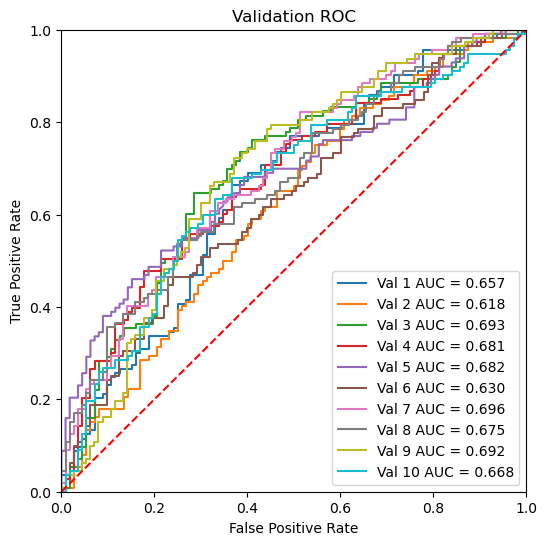

In [19]:
i=1
tprs_val = []
mean_fpr_val = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Validation ROC')
for fpr_val,tpr_val,roc_auc_val in zip(fpr_list_val,tpr_list_val,roc_auc_list_val):
    tprs_val.append(np.interp(mean_fpr_val, fpr_val, tpr_val))
    tprs_val[-1][0] = 0.0
    plt.plot(fpr_val, tpr_val, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_val)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_val.png')
plt.show()

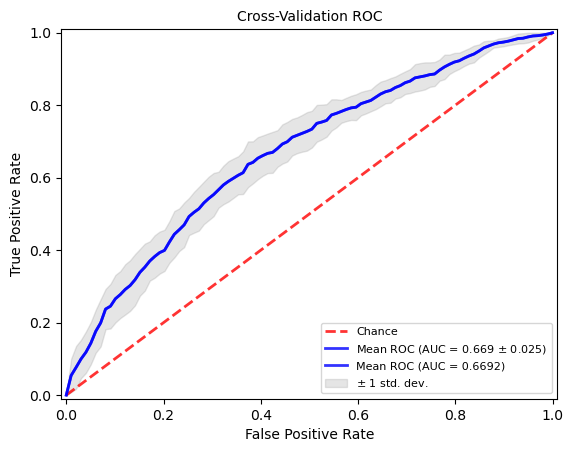

In [20]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_val = np.mean(tprs_val, axis=0)
mean_tpr_val[-1] = 1.0
mean_auc_val = auc(mean_fpr_val, mean_tpr_val)
std_auc_val = np.std(roc_auc_list_val)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_val, std_auc_val),lw=2, alpha=.8)
plt.plot(mean_fpr_val, mean_tpr_val, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_val),lw=2, alpha=.8)
std_tpr_val = np.std(tprs_val, axis=0)
tprs_upper_val = np.minimum(mean_tpr_val + std_tpr_val, 1)
tprs_lower_val = np.maximum(mean_tpr_val - std_tpr_val, 0)
plt.fill_between(mean_fpr_val, tprs_lower_val, tprs_upper_val, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Cross-Validation ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_val_mean.png')
plt.show()

In [21]:
def calculate_metrics_val(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [22]:
my_calculate_metrics_list_val = []
for score_val,lable_val in zip(scores_val,lables_val):
    val_my_calculate_metrics = calculate_metrics_val(lable_val,score_val)
    my_calculate_metrics_list_val.append(val_my_calculate_metrics)

In [23]:
my_calculate_metrics_list_val

[{'SN': 0.7079646017699115,
  'SP': 0.5535714285714286,
  'ACC': 0.6311111111111111,
  'MCC': 0.26475628705052545,
  'Recall': 0.7079646017699115,
  'Precision': 0.6153846153846154,
  'F1-score': 0.6584362139917695,
  'Cutoff': 0.5},
 {'SN': 0.48214285714285715,
  'SP': 0.6607142857142857,
  'ACC': 0.5714285714285714,
  'MCC': 0.14519080172812554,
  'Recall': 0.48214285714285715,
  'Precision': 0.5869565217391305,
  'F1-score': 0.5294117647058824,
  'Cutoff': 0.5},
 {'SN': 0.7079646017699115,
  'SP': 0.6339285714285714,
  'ACC': 0.6711111111111111,
  'MCC': 0.3428698577969706,
  'Recall': 0.7079646017699115,
  'Precision': 0.6611570247933884,
  'F1-score': 0.6837606837606838,
  'Cutoff': 0.5},
 {'SN': 0.7787610619469026,
  'SP': 0.45535714285714285,
  'ACC': 0.6177777777777778,
  'MCC': 0.24750472146080194,
  'Recall': 0.7787610619469026,
  'Precision': 0.5906040268456376,
  'F1-score': 0.6717557251908397,
  'Cutoff': 0.5},
 {'SN': 0.6814159292035398,
  'SP': 0.5714285714285714,
  'ACC

In [24]:
performance_val=pd.DataFrame(my_calculate_metrics_list_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.707965,0.553571,0.631111,0.264756,0.707965,0.615385,0.658436,0.5
1,0.482143,0.660714,0.571429,0.145191,0.482143,0.586957,0.529412,0.5
2,0.707965,0.633929,0.671111,0.342870,0.707965,0.661157,0.683761,0.5
3,0.778761,0.455357,0.617778,0.247505,0.778761,0.590604,0.671756,0.5
4,0.681416,0.571429,0.626667,0.254417,0.681416,0.616000,0.647059,0.5
5,0.616071,0.566372,0.591111,0.182660,0.616071,0.584746,0.600000,0.5
6,0.758929,0.513274,0.635556,0.280716,0.758929,0.607143,0.674603,0.5
7,0.669643,0.513274,0.591111,0.185169,0.669643,0.576923,0.619835,0.5
8,0.794643,0.539823,0.666667,0.345741,0.794643,0.631206,0.703557,0.5
9,0.669643,0.633929,0.651786,0.303765,0.669643,0.646552,0.657895,0.5


In [25]:
std_val = performance_val.std(axis = 0,ddof=1)
mean_val = performance_val.mean(axis = 0)
data_mean_val = pd.DataFrame(mean_val)
data_mean_val = data_mean_val.T
data_std_val = pd.DataFrame(std_val)
data_std_val = data_std_val.T
performance_val = performance_val.append(data_mean_val)
performance_val = performance_val.append(data_std_val)
performance_val

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.707965,0.553571,0.631111,0.264756,0.707965,0.615385,0.658436,0.5
1,0.482143,0.660714,0.571429,0.145191,0.482143,0.586957,0.529412,0.5
2,0.707965,0.633929,0.671111,0.342870,0.707965,0.661157,0.683761,0.5
3,0.778761,0.455357,0.617778,0.247505,0.778761,0.590604,0.671756,0.5
4,0.681416,0.571429,0.626667,0.254417,0.681416,0.616000,0.647059,0.5
5,0.616071,0.566372,0.591111,0.182660,0.616071,0.584746,0.600000,0.5
6,0.758929,0.513274,0.635556,0.280716,0.758929,0.607143,0.674603,0.5
7,0.669643,0.513274,0.591111,0.185169,0.669643,0.576923,0.619835,0.5
8,0.794643,0.539823,0.666667,0.345741,0.794643,0.631206,0.703557,0.5
9,0.669643,0.633929,0.651786,0.303765,0.669643,0.646552,0.657895,0.5


In [26]:
performance_val.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\result\CNN_OH_performance_val.csv',encoding='utf-8')

独立测试

In [27]:
#遍历表格求初始里程
#独立测试
import os
path = r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\result\indep'
filenames=os.listdir(path)#得到字符串列表
scores_indep=[]
lables_indep=[]
fpr_list_indep = []
tpr_list_indep = []
roc_auc_list_indep=[]
i=0
for filename in filenames:
        true_path=path+r'\\'+filename
        data=pd.read_csv(true_path,engine='python')
        score_indep=data.iloc[:,1]
        scores_indep.append(score_indep)
        lable_indep = data.iloc[:,2]
        lables_indep.append(lable_indep)
        fpr_indep,tpr_indep,thresholds_indep= roc_curve(lables_indep[i],scores_indep[i])   #y_true,y_score
        fpr_list_indep.append(fpr_indep)
        tpr_list_indep.append(tpr_indep)
        roc_auc_indep = auc(fpr_indep,tpr_indep)
        roc_auc_list_indep.append(roc_auc_indep)
        i+=1

In [28]:
roc_auc_list_indep

[0.6831154336734694,
 0.6887755102040817,
 0.6979432397959182,
 0.6897321428571429,
 0.6849489795918366,
 0.6949139030612245,
 0.6882174744897959,
 0.6739477040816327,
 0.6828762755102041,
 0.690688775510204]

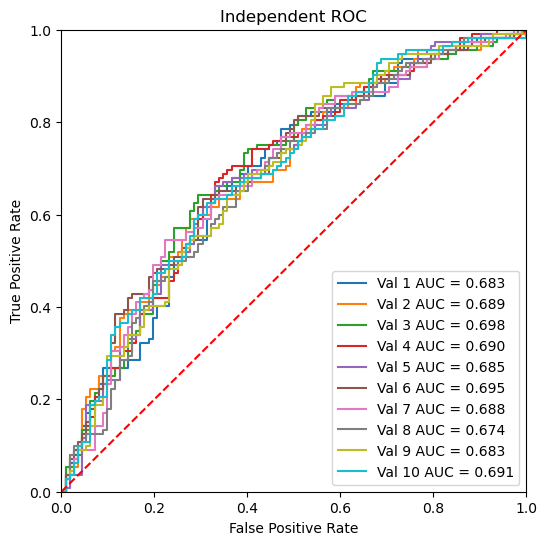

In [29]:
i=1
tprs_indep = []
mean_fpr_indep = np.linspace(0, 1, 100)
plt.figure(figsize=(6,6))
plt.title('Independent ROC')
for fpr_indep,tpr_indep,roc_auc_indep in zip(fpr_list_indep,tpr_list_indep,roc_auc_list_indep):
    tprs_indep.append(np.interp(mean_fpr_indep, fpr_indep, tpr_indep))
    tprs_indep[-1][0] = 0.0
    plt.plot(fpr_indep, tpr_indep, label = 'Val ' + str(i) + ' AUC = %0.3f' % roc_auc_indep)
    i+=1
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('CNN_OH_indep.png')
plt.show()

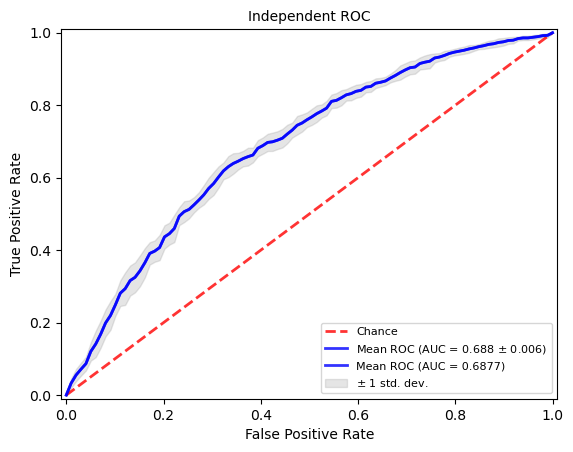

In [30]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',label='Chance', alpha=.8)
mean_tpr_indep = np.mean(tprs_indep, axis=0)
mean_tpr_indep[-1] = 1.0
mean_auc_indep = auc(mean_fpr_indep, mean_tpr_indep)
std_auc_indep = np.std(roc_auc_list_indep)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_indep, std_auc_indep),lw=2, alpha=.8)
plt.plot(mean_fpr_indep, mean_tpr_indep, color='b',label=r'Mean ROC (AUC = %0.4f)' % (mean_auc_indep),lw=2, alpha=.8)
std_tpr_indep = np.std(tprs_indep, axis=0)
tprs_upper_indep = np.minimum(mean_tpr_indep + std_tpr_indep, 1)
tprs_lower_indep = np.maximum(mean_tpr_indep - std_tpr_indep, 0)
plt.fill_between(mean_fpr_indep, tprs_lower_indep, tprs_upper_indep, color='grey', alpha=.2,label=r'$\pm$ 1 std. dev.')
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate',fontsize=10)
plt.ylabel('True Positive Rate',fontsize=10)
plt.title('Independent ROC',fontsize=10)
plt.legend(loc="lower right", prop={'size': 8})
plt.savefig('CNN_OH_indep_mean.png')
plt.show()

In [31]:
def calculate_metrics_indep(labels, scores, cutoff=0.5, po_label=1):  # 计算阈值为0.5时的各性能指数
    my_metrics = {  # 先声明建立一个字典，对应KEY值
        'SN': 'NA',
        'SP': 'NA',
        'ACC': 'NA',
        'MCC': 'NA',
        'Recall': 'NA',
        'Precision': 'NA',
        'F1-score': 'NA',
        'Cutoff': cutoff,
    }
    tp, tn, fp, fn = 0, 0, 0, 0
    for i in range(len(scores)):
        if labels[i] == po_label:  # 如果为正样本
            if scores[i] >= cutoff:  # 阈值为0.5，如果打分大于0.5
                tp = tp + 1  # tp+1  预测为真，实际为真的
            else:
                fn = fn + 1  # 预测为真，实际为负
        else:  # 如果为负样本
            if scores[i] < cutoff:  # 打分小于阈值，说明实际为负，预测也为负
                tn = tn + 1  # tn+1
            else:
                fp = fp + 1  # 打分大于阈值，说明实际为负，预测为正
    my_metrics['SN'] = tp / (tp + fn) if (tp + fn) != 0 else 'NA'  # sn 灵敏度
    my_metrics['SP'] = tn / (fp + tn) if (fp + tn) != 0 else 'NA'  # sp 特异性
    my_metrics['ACC'] = (tp + tn) / (tp + fn + tn + fp)  # acc正确度
    my_metrics['MCC'] = (tp * tn - fp * fn) / np.math.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) if ( tp + fp) * ( tp + fn) * ( tn + fp) * ( tn + fn) != 0 else 'NA'
    my_metrics['Precision'] = tp / (tp + fp) if (tp + fp) != 0 else 'NA'  # 查准率
    my_metrics['Recall'] = my_metrics['SN']  # 召回率
    my_metrics['F1-score'] = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) != 0 else 'NA'
    return my_metrics

In [32]:
my_calculate_metrics_list_indep = []
for score_indep,lable_indep in zip(scores_indep,lables_indep):
    indep_my_calculate_metrics = calculate_metrics_indep(lable_indep,score_indep)
    my_calculate_metrics_list_indep.append(indep_my_calculate_metrics)

In [33]:
my_calculate_metrics_list_indep

[{'SN': 0.75,
  'SP': 0.5535714285714286,
  'ACC': 0.6517857142857143,
  'MCC': 0.30960307333462006,
  'Recall': 0.75,
  'Precision': 0.6268656716417911,
  'F1-score': 0.6829268292682927,
  'Cutoff': 0.5},
 {'SN': 0.5535714285714286,
  'SP': 0.7321428571428571,
  'ACC': 0.6428571428571429,
  'MCC': 0.2903816034562511,
  'Recall': 0.5535714285714286,
  'Precision': 0.6739130434782609,
  'F1-score': 0.6078431372549019,
  'Cutoff': 0.5},
 {'SN': 0.7321428571428571,
  'SP': 0.6071428571428571,
  'ACC': 0.6696428571428571,
  'MCC': 0.341967856532158,
  'Recall': 0.7321428571428571,
  'Precision': 0.6507936507936508,
  'F1-score': 0.6890756302521008,
  'Cutoff': 0.5},
 {'SN': 0.7767857142857143,
  'SP': 0.48214285714285715,
  'ACC': 0.6294642857142857,
  'MCC': 0.27095704736911225,
  'Recall': 0.7767857142857143,
  'Precision': 0.6,
  'F1-score': 0.6770428015564203,
  'Cutoff': 0.5},
 {'SN': 0.6964285714285714,
  'SP': 0.5625,
  'ACC': 0.6294642857142857,
  'MCC': 0.26128246839318153,
  'Rec

In [34]:
performance_indep=pd.DataFrame(my_calculate_metrics_list_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.750000,0.553571,0.651786,0.309603,0.750000,0.626866,0.682927,0.5
1,0.553571,0.732143,0.642857,0.290382,0.553571,0.673913,0.607843,0.5
2,0.732143,0.607143,0.669643,0.341968,0.732143,0.650794,0.689076,0.5
3,0.776786,0.482143,0.629464,0.270957,0.776786,0.600000,0.677043,0.5
4,0.696429,0.562500,0.629464,0.261282,0.696429,0.614173,0.652720,0.5
5,0.687500,0.580357,0.633929,0.269408,0.687500,0.620968,0.652542,0.5
6,0.794643,0.455357,0.625000,0.265764,0.794643,0.593333,0.679389,0.5
7,0.723214,0.553571,0.638393,0.280857,0.723214,0.618321,0.666667,0.5
8,0.714286,0.535714,0.625000,0.254084,0.714286,0.606061,0.655738,0.5
9,0.660714,0.633929,0.647321,0.294749,0.660714,0.643478,0.651982,0.5


In [35]:
std_indep = performance_indep.std(axis = 0,ddof=1)
mean_indep = performance_indep.mean(axis = 0)
data_mean_indep = pd.DataFrame(mean_indep)
data_mean_indep = data_mean_indep.T
data_std_indep = pd.DataFrame(std_indep)
data_std_indep = data_std_indep.T
performance_indep = performance_indep.append(data_mean_indep)
performance_indep = performance_indep.append(data_std_indep)
performance_indep

,SN,SP,ACC,MCC,Recall,Precision,F1-score,Cutoff
0,0.750000,0.553571,0.651786,0.309603,0.750000,0.626866,0.682927,0.5
1,0.553571,0.732143,0.642857,0.290382,0.553571,0.673913,0.607843,0.5
2,0.732143,0.607143,0.669643,0.341968,0.732143,0.650794,0.689076,0.5
3,0.776786,0.482143,0.629464,0.270957,0.776786,0.600000,0.677043,0.5
4,0.696429,0.562500,0.629464,0.261282,0.696429,0.614173,0.652720,0.5
5,0.687500,0.580357,0.633929,0.269408,0.687500,0.620968,0.652542,0.5
6,0.794643,0.455357,0.625000,0.265764,0.794643,0.593333,0.679389,0.5
7,0.723214,0.553571,0.638393,0.280857,0.723214,0.618321,0.666667,0.5
8,0.714286,0.535714,0.625000,0.254084,0.714286,0.606061,0.655738,0.5
9,0.660714,0.633929,0.647321,0.294749,0.660714,0.643478,0.651982,0.5


In [36]:
performance_indep.to_csv(r'D:\PycharmProjects\pythonProject\Papernew_datachangetry\model\target_model\NEDD_K\layer_NEDD_K_不自然数据集\freeze_all\result\CNN_OH_performance_indep.csv',encoding='utf-8')

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

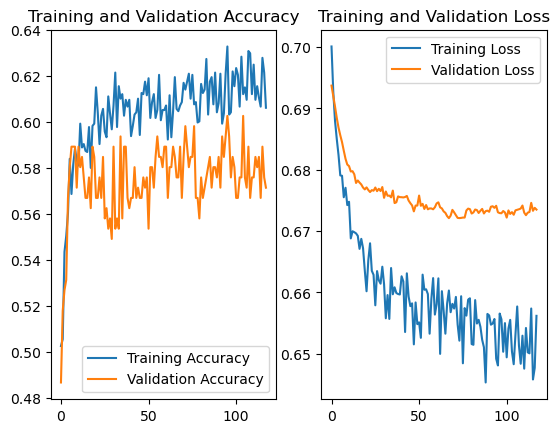

In [38]:
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()